# Comparing TCdata360 and Govdata360 indicator lists
Data sources:
- For TCdata360 indicator list: http://tcdata360-backend.worldbank.org/api/v1/indicators/
- For Govdata360 indicator list: http://govdata360-backend.worldbank.org/api/v1/indicators/


## Import Modules

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import datetime

import re
from nltk import distance
from fuzzywuzzy import fuzz, process

%matplotlib inline

C:\Users\mrpso\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
date_today = datetime.date.today().isoformat()

## Generate TCdata360 and Govdata360 indicator datasets

In [43]:
url ='http://tcdata360-backend.worldbank.org/api/v1/indicators/'
response = requests.get(url)
tc_indicators = pd.read_json(response.text)
tc_indicators.shape

(2095, 16)

In [42]:
url ='http://govdata360-backend.worldbank.org/api/v1/indicators/'
response = requests.get(url)
gv_indicators = pd.read_json(response.text)
gv_indicators.shape

(3230, 16)

# Comparing TCdata360 and Govdata360 indicator lists

## Pre-processing: Normalizing and tokenizing indicator names

In [44]:
tc_indicators['name_lower'] = tc_indicators['name'].apply(lambda x: x.lower().strip())
gv_indicators['name_lower'] = gv_indicators['name'].apply(lambda x: x.lower().strip())

To increase chances of matching, we also replace commonly used symbols such as:
- "%" or "proportion" to "percent"
- "#" to "number"
- '/' to "per"
- replace oth special characters (e.g., -, ?, .) except $ with blanks.

In [45]:
gv_indicators['name_lower'] = gv_indicators['name_lower'].apply(lambda x: x.replace("%", "percent").replace("proportion", "percent").replace("#", "number").replace("/", " per "))
tc_indicators['name_lower'] = tc_indicators['name_lower'].apply(lambda x: x.replace("%", "percent").replace("proportion", "percent").replace("#", "number").replace("/", " per "))

In [46]:
tc_indicators['name_lower'] = tc_indicators['name_lower'].apply(lambda x: re.sub('[^\w$ ]', '', x))
gv_indicators['name_lower'] = gv_indicators['name_lower'].apply(lambda x: re.sub('[^\w$ ]', '', x))

In [47]:
tc_indicators['name_lower'] = tc_indicators['name_lower'].apply(lambda x: re.sub('[_]', ' ', x))
gv_indicators['name_lower'] = gv_indicators['name_lower'].apply(lambda x: re.sub('[_]', ' ', x))

In [48]:
tc_indicators[['name','name_lower']].head()

,name,name_lower
0,GDP growth (annual %),gdp growth annual percent
1,"Venture capital availability, 1-7 (best)",venture capital availability 17 best
2,"Venture capital availability, 1-7 (best)",venture capital availability 17 best
3,Research and development expenditure (% of GDP),research and development expenditure percent o...
4,"Foreign direct investment, net inflows (% of GDP)",foreign direct investment net inflows percent ...


In [49]:
gv_indicators[['name','name_lower']].tail()

,name,name_lower
3225,11_11 Civil Society Organizations,11 11 civil society organizations
3226,77a_In practice the government does not detain...,77a in practice the government does not detain...
3227,27a_In law the judiciary can review the action...,27a in law the judiciary can review the action...
3228,18f_In law there are requirements for the inde...,18f in law there are requirements for the inde...
3229,73d_In practice citizens earning the median ye...,73d in practice citizens earning the median ye...


## Shortlisting datasets common to both indicators
- Assumption: ease in API ingestion only works if the dataset for both TCdata360 and Govdata360 indicators are the same. Even if it's the same indicator name but coming from different dataset sources for TCdata360 and Govdata360, the matching doesn't apply.
- Rationale: this speeds up the matching process since it reduces the number of indicator pairs to be checked.

In [245]:
set(tc_indicators['dataset'])

{'Bertelsmann Transformation Index',
 'Citizen Engagement in Rulemaking',
 'Competitive Industrial Performance Index',
 'Direction of Trade',
 'Doing Business',
 'ESCAP',
 'Enabling the Business of Agriculture',
 'Enterprise Surveys',
 'Entrepreneurship at a Glance',
 'Environmental Performance Index',
 'Global Entrepreneurship Monitor Adult Population Survey',
 'Global Entrepreneurship Monitor National Expert Survey',
 'Heritage Index of Economic Freedom',
 'I-TIP Goods',
 'I-TIP Services',
 'ITU Database',
 'Investing Across Borders',
 'Logistics Performance Index',
 'Measuring Export Competitiveness',
 'Networked Readiness index',
 'OECD Innovation Indicators',
 'OECD Product Market Regulation Database',
 'Services Trade Restrictiveness Index',
 'Sustainable Energy For All',
 'Temporary Trade Barriers Database',
 'Timely Indicators of Entrepreneurship',
 'Trade in Value Added',
 'Travel & Tourism Competitiveness Index',
 'UNCTAD',
 'UNCTAD Cyberlaw Tracker',
 'UPU',
 'United Nations

In [246]:
set(gv_indicators['dataset'])

{'Bertelsmann Transformation Index',
 'Corruption Perceptions Index',
 'Country Policy and Institutional Assessments',
 'Doing Business',
 'Enterprise Surveys',
 'Failed States Index',
 'Fiscal Rules Dataset',
 'Global Competitiveness Index',
 'Global Indicators of Regulatory Governance',
 'Global Integrity Index',
 'Human Resource Management',
 'IBP Open Budget Index',
 'Ibrahim Index of African Governance',
 'Inter-Parliamentary Union',
 'PEFA',
 'Pay and Employment',
 'Polity IV',
 'Public Accountability Mechanisms Freedom of Information',
 'Public Accountability Mechanisms Income and Disclosure',
 'Public Investment Management',
 'Quality of Govt',
 'Statistical Capacity',
 'Sustainable Governance Indicators',
 'Women, Business and the Law',
 'World Justice Project',
 'Worldwide Governance Indicators'}

In [247]:
common_datasets = list(set(tc_indicators['dataset']) & set(gv_indicators['dataset'])) + ['World Economic Forum Global Competitiveness Index', 'Global Competitiveness Index']
common_datasets

['Women, Business and the Law',
 'Doing Business',
 'Bertelsmann Transformation Index',
 'Worldwide Governance Indicators',
 'Enterprise Surveys',
 'World Economic Forum Global Competitiveness Index',
 'Global Competitiveness Index']

In [248]:
gv_indicators[gv_indicators['dataset'].isin(common_datasets)].shape

(524, 17)

In [249]:
tc_indicators[tc_indicators['dataset'].isin(common_datasets)].shape

(602, 17)

We look at the number of indicators per dataset.

In [250]:
common_datasets = [[dataset] for dataset in list(set(tc_indicators['dataset']) & set(gv_indicators['dataset']))] + [['World Economic Forum Global Competitiveness Index', 'Global Competitiveness Index']]
common_datasets

[['Women, Business and the Law'],
 ['Doing Business'],
 ['Bertelsmann Transformation Index'],
 ['Worldwide Governance Indicators'],
 ['Enterprise Surveys'],
 ['World Economic Forum Global Competitiveness Index',
  'Global Competitiveness Index']]

In [251]:
dataset_count = {}
for dataset in common_datasets:
    tc_count = tc_indicators[tc_indicators['dataset'].isin(dataset)].shape[0]
    gv_count = gv_indicators[gv_indicators['dataset'].isin(dataset)].shape[0]
    dataset_count[dataset[0]] = [tc_count, gv_count]
    
df_dataset_count = pd.DataFrame(dataset_count).T
df_dataset_count.columns = ['tc_indicator_count', 'gv_indicator_count']

In [252]:
df_dataset_count

,tc_indicator_count,gv_indicator_count
Bertelsmann Transformation Index,3,52
Doing Business,76,108
Enterprise Surveys,121,118
"Women, Business and the Law",132,132
World Economic Forum Global Competitiveness Index,240,108
Worldwide Governance Indicators,30,6


## Matching indicators using  `fuzzywuzzy` ratio, partial ratio, token sort ratio, and token set ratio

We generate the fuzzywuzzy statistics for all indicator pairs for all datasets.

In [253]:
df_name_lower_comp_all = pd.DataFrame()
fuzz_stats = ['ratio', 'partial_ratio', 'token_sort_ratio', 'token_set_ratio']
df_cols = ['gv_indicator', 'tc_indicator', 'ratio', 'partial_ratio', 'token_sort_ratio', 'token_set_ratio']

for dataset in common_datasets:
    tc_indicators_shortlist = tc_indicators[tc_indicators['dataset'].isin(dataset)]
    gv_indicators_shortlist = gv_indicators[gv_indicators['dataset'].isin(dataset)]

    tc_list = list(set(tc_indicators_shortlist['name_lower']))
    gv_list = list(set(gv_indicators_shortlist['name_lower']))

    name_lower_comparison_fuzz = []
    for gv_ind in gv_list:
        for tc_ind in tc_list:
            name_lower_comparison_fuzz.append([gv_ind,tc_ind, fuzz.ratio(gv_ind,tc_ind), fuzz.partial_ratio(gv_ind,tc_ind), fuzz.token_sort_ratio(gv_ind,tc_ind),  fuzz.token_set_ratio(gv_ind,tc_ind)])
        
    df_name_lower_comparison_fuzz = pd.DataFrame(name_lower_comparison_fuzz, columns = df_cols)
    df_name_lower_comparison_fuzz['stat_mean'] = df_name_lower_comparison_fuzz[fuzz_stats].mean(axis=1)
    df_name_lower_comparison_fuzz['stat_min'] = df_name_lower_comparison_fuzz[fuzz_stats].min(axis=1)
    df_name_lower_comparison_fuzz['stat_max'] = df_name_lower_comparison_fuzz[fuzz_stats].max(axis=1)

    df_name_lower_comparison_fuzz['source_dataset'] = dataset[0]
    df_name_lower_comp_all = df_name_lower_comp_all.append(df_name_lower_comparison_fuzz)

In [254]:
df_name_lower_comp_all.head()

,gv_indicator,tc_indicator,ratio,partial_ratio,token_sort_ratio,token_set_ratio,stat_mean,stat_min,stat_max,source_dataset
0,what is the age at which a man can retire and ...,what is the age at which a man can retire and ...,100,100,100,100,100.0,100,100,"Women, Business and the Law"
1,what is the age at which a man can retire and ...,can nonpregnant and nonnursing women engage in...,21,37,40,32,32.5,21,40,"Women, Business and the Law"
2,what is the age at which a man can retire and ...,do protection orders cover prohibition of cont...,19,25,38,36,29.5,19,38,"Women, Business and the Law"
3,what is the age at which a man can retire and ...,does the law mandate paid or unpaid paternity ...,40,45,35,36,39.0,35,45,"Women, Business and the Law"
4,what is the age at which a man can retire and ...,is personal law recognized as a valid source o...,19,30,44,43,34.0,19,44,"Women, Business and the Law"


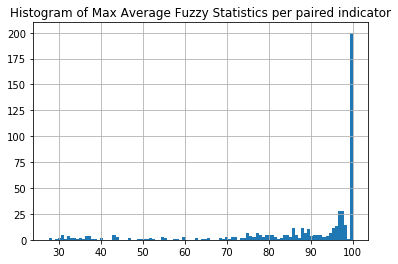

In [255]:
df_name_lower_comp_all.groupby('gv_indicator')['stat_mean'].max().hist(bins=100)
plt.title('Histogram of Max Average Fuzzy Statistics per paired indicator')

(95, 100)

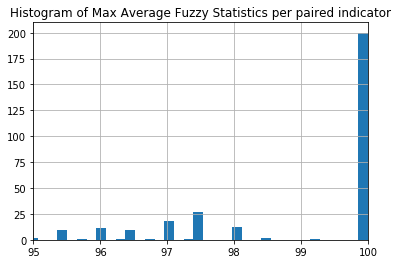

In [256]:
df_name_lower_comp_all.groupby('gv_indicator')['stat_mean'].max().hist(bins=500)
plt.title('Histogram of Max Average Fuzzy Statistics per paired indicator')
plt.xlim(95,100)

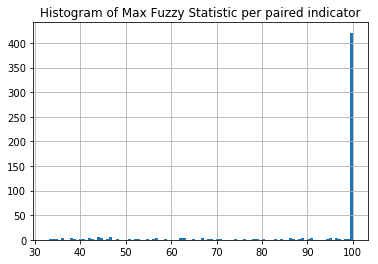

In [257]:
df_name_lower_comp_all.groupby('gv_indicator')['stat_max'].max().hist(bins=100)
plt.title('Histogram of Max Fuzzy Statistic per paired indicator')

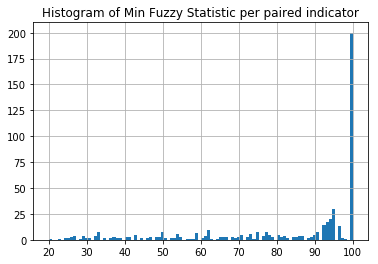

In [258]:
df_name_lower_comp_all.groupby('gv_indicator')['stat_min'].max().hist(bins=100)
plt.title('Histogram of Min Fuzzy Statistic per paired indicator')

# Generating Matched Indicator Shortlists
## Automated Matching: Generate Top 1 High-accuracy Matched Indicators
For high-accuracy match results, we automatically generate the top 1 matched indicator.

Based on iterations to improve results, we choose the ff. cut off points using the ff. fuzzy statistics: ratio, partial ratio, token set ratio, token sort ratio
- Get top match based on average fuzzy statistics.
- Keep matches which satisfy all of the ff.:
    - Average fuzzy statistics at least 80
    - Minimum fuzzy statistic is at least 70

In [259]:
df_name_lower_comp_fuzz_top1 = df_name_lower_comp_all.groupby('gv_indicator').apply(lambda x: x.sort_values(by='stat_mean', ascending=False).head(1)).reset_index(drop=True)
df_name_lower_comp_fuzz_top1_filtered = df_name_lower_comp_fuzz_top1[(df_name_lower_comp_fuzz_top1['stat_mean'] >= 80) & (df_name_lower_comp_fuzz_top1['stat_min'] >= 70)].reset_index(drop=True).reset_index()

In [260]:
pd.DataFrame(df_name_lower_comp_fuzz_top1_filtered['source_dataset'].value_counts().sort_index())

,source_dataset
Bertelsmann Transformation Index,3
Doing Business,61
Enterprise Surveys,106
"Women, Business and the Law",131
World Economic Forum Global Competitiveness Index,81
Worldwide Governance Indicators,3


In [261]:
df_name_lower_comp_fuzz_top1_filtered.shape

(385, 11)

In [262]:
df_name_lower_comp_fuzz_top1_filtered.to_csv("%s-TC-Gov_High-Accuracy_Automatic-Matched-Indicators.csv" % (date_today), index=False)

Merge Top 1 High-accuracy list with full indicator data.

In [276]:
df_name_lower_comp_fuzz_top1_filtered_short = df_name_lower_comp_fuzz_top1_filtered[['index', 'gv_indicator', 'tc_indicator', 'source_dataset']]
tc_shortlist_fuzz = tc_indicators.merge(df_name_lower_comp_fuzz_top1_filtered_short, how='inner', left_on=['name_lower', 'dataset'], right_on=['tc_indicator', 'source_dataset']).drop(['source_dataset', 'tc_indicator','gv_indicator'], axis=1)
gv_shortlist_fuzz = gv_indicators.replace({'dataset': {'Global Competitiveness Index': 'World Economic Forum Global Competitiveness Index'}}).merge(df_name_lower_comp_fuzz_top1_filtered_short, how='inner', left_on=['name_lower', 'dataset'], right_on=['gv_indicator', 'source_dataset']).drop(['source_dataset', 'tc_indicator','gv_indicator'], axis=1)

merged_shortlist_fuzz = tc_shortlist_fuzz.merge(gv_shortlist_fuzz, how='inner', on=['index'], suffixes = ('_tc', '_gv'))
merged_shortlist_fuzz = merged_shortlist_fuzz.merge(df_name_lower_comp_fuzz_top1_filtered, on='index')

In [277]:
merged_shortlist_fuzz.to_csv("%s-TC-Gov_High-Accuracy_Automatic-Matched-Indicators_complete.csv" % (date_today), index=False)

## Semi-automated Matching: Generate Possible Matches Shortlist for Low-Accuracy Matched Indicators
For low-accuracy match results, we generate the top 5 matches per fuzzy statistic (which gives at most 20 matches per Govdata360 indicator).
 
The user can then manually pick the best match from this shortlist. To make manual search easier, we only keep all unique suggested matches and sort unique results based on score.

In [265]:
df_name_lower_comp_fuzz_low_acc = df_name_lower_comp_fuzz_top1[~((df_name_lower_comp_fuzz_top1['stat_mean'] >= 80) & (df_name_lower_comp_fuzz_top1['stat_min'] >= 70))][['gv_indicator', 'source_dataset']]

In [266]:
df_name_lower_comp_all_choices = pd.DataFrame()
df_cols = ['gv_indicator', 'source_dataset', 'ratio1', 'ratio2', 'ratio3', 'token_sort1', 'token_sort2', 'token_sort3']

for dataset in common_datasets:
    tc_list = list(set(tc_indicators[tc_indicators['dataset'].isin(dataset)]['name_lower']))
    gv_list = list(set(df_name_lower_comp_fuzz_low_acc[df_name_lower_comp_fuzz_low_acc['source_dataset'].isin(dataset)]['gv_indicator']))

    name_lower_comparison_fuzz = []
    for gv_ind in gv_list:
        for val in process.extract(gv_ind, tc_list, scorer=fuzz.ratio, limit=5):
            name_lower_comparison_fuzz.append([gv_ind, val[0], val[1], dataset[0]])
        for val in process.extract(gv_ind, tc_list, scorer=fuzz.partial_ratio, limit=5):
            name_lower_comparison_fuzz.append([gv_ind, val[0], val[1], dataset[0]])
        for val in process.extract(gv_ind, tc_list, scorer=fuzz.token_set_ratio, limit=5):
            name_lower_comparison_fuzz.append([gv_ind, val[0], val[1], dataset[0]])
        for val in process.extract(gv_ind, tc_list, scorer=fuzz.token_sort_ratio, limit=5):
            name_lower_comparison_fuzz.append([gv_ind, val[0], val[1], dataset[0]])
        
    df_name_lower_comparison_fuzz = pd.DataFrame(name_lower_comparison_fuzz, columns = ['gv_indicator', 'tc_indicator','match_score', 'source_dataset'])
    df_name_lower_comparison_fuzz.drop_duplicates(subset = ['gv_indicator', 'tc_indicator', 'source_dataset'], inplace=True)
    df_name_lower_comparison_fuzz.sort_values(by='match_score', ascending=False)
    df_name_lower_comp_all_choices = df_name_lower_comp_all_choices.append(df_name_lower_comparison_fuzz)

df_name_lower_comp_all_choices.reset_index(inplace=True, drop=True)

In [267]:
df_name_lower_comp_all_choices['match?'] = np.nan
df_name_lower_comp_all_choices = df_name_lower_comp_all_choices[['gv_indicator', 'tc_indicator','match?', 'match_score', 'source_dataset']]
df_name_lower_comp_all_choices.to_csv("%s-TC-Gov_Low-Accuracy_Semi-Automatic-Matched-Indicators-Choices.csv" % (date_today), index=False)

We import the filled-out CSV with manual matching.

In [268]:
df_manual_matching = pd.read_csv("2017-07-05-TC-Gov_Low-Accuracy_Semi-Automatic-Matched-Indicators-Choices_with-manual-matching.csv")
df_manual_matching = df_manual_matching[df_manual_matching['match?'] == 1.0].reset_index(drop=True).reset_index()

In [269]:
df_manual_matching.head()

,index,gv_indicator,tc_indicator,match?,match_score,source_dataset
0,0,starting a business procedure women number,procedures to start a business number,1.0,57,Doing Business
1,1,paying taxes payments number per year,tax payments numberperyear,1.0,81,Doing Business
2,2,getting credit depth of credit information in...,depth of credit information index 08,1.0,67,Doing Business
3,3,protecting minority investors extent of share...,extent of shareholder governance index 010,1.0,59,Doing Business
4,4,starting a business time women days,time to start a business days,1.0,64,Doing Business


In [273]:
df_manual_matching_matches = df_manual_matching[['index', 'gv_indicator', 'tc_indicator', 'source_dataset']]
tc_shortlist_fuzz = tc_indicators.merge(df_manual_matching_matches, how='inner', left_on=['name_lower', 'dataset'], right_on=['tc_indicator', 'source_dataset']).drop(['source_dataset', 'tc_indicator','gv_indicator'], axis=1)
gv_shortlist_fuzz = gv_indicators.replace({'dataset': {'Global Competitiveness Index': 'World Economic Forum Global Competitiveness Index'}}).merge(df_manual_matching_matches, how='inner', left_on=['name_lower', 'dataset'], right_on=['gv_indicator', 'source_dataset']).drop(['source_dataset', 'tc_indicator','gv_indicator'], axis=1)

merged_shortlist_fuzz_manual = tc_shortlist_fuzz.merge(gv_shortlist_fuzz, how='inner', on=['index'], suffixes = ('_tc', '_gv'))
merged_shortlist_fuzz_manual = merged_shortlist_fuzz_manual.merge(df_manual_matching_matches, on='index')

In [274]:
merged_shortlist_fuzz_manual.head()

,byPartner_tc,byProduct_tc,dataset_tc,datasetId_tc,dateRange_tc,defaultViz_tc,definition_tc,doNotUseViz_tc,id_tc,name_tc,...,periodicity_gv,rank_gv,subindicatorType_gv,timeframes_gv,units_gv,valueType_gv,name_lower_gv,gv_indicator,tc_indicator,source_dataset
0,False,False,Doing Business,52,2004-2017,line_chart,Time is recorded in calendar days. The measure...,"[spider_chart, slope_graph, chord_diagram]",459,Time to start a business (days),...,annually,4.086,Total,"[2004, 2005, 2006, 2007, 2008, 2009, 2010, 201...",Count,Total,starting a business time women days,starting a business time women days,time to start a business days,Doing Business
1,False,False,Enterprise Surveys,49,2005-2016,line_chart,Percentage of firms identifying business licen...,"[spider_chart, slope_graph, chord_diagram]",308,% of firms identifying business licensing and ...,...,annually,2.060,Total,"[2006, 2007, 2008, 2009, 2010, 2011, 2012, 201...",Count,Total,business licensing and permits,business licensing and permits,percent of firms identifying business licensin...,Enterprise Surveys
2,False,False,Doing Business,52,2014-2017,line_chart,The rules and practices affecting the coverage...,"[spider_chart, slope_graph, chord_diagram]",444,Depth of credit information index (0-8),...,annually,4.309,Total,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Count,Total,getting credit depth of credit information in...,getting credit depth of credit information in...,depth of credit information index 08,Doing Business
3,False,False,Doing Business,52,2016-2017,line_chart,The quality of judicial processes index measur...,"[spider_chart, slope_graph, chord_diagram]",478,Quality of judicial processes to enforce contr...,...,once,4.258,Total,[2016],Count,Total,enforcing contracts quality of judicial proce...,enforcing contracts quality of judicial proce...,quality of judicial processes to enforce contr...,Doing Business
4,False,False,Worldwide Governance Indicators,51,1996-2015,line_chart,Perceptions of the likelihood of political ins...,"[spider_chart, slope_graph, chord_diagram]",376,Political stability score (-2.5 to 2.5),...,annually,1.020,Upper,"[1996, 1998, 2000, 2002, 2003, 2004, 2005, 200...",Yes/No,Upper,political stability no violence,political stability no violence,political stability score 25 to 25,Worldwide Governance Indicators


In [275]:
merged_shortlist_fuzz_manual.to_csv("%s-TC-Gov_High-Accuracy_Automatic-Matched-Indicators_complete.csv" % (date_today), index=False)

In [278]:
merged_shortlist_fuzz.shape, merged_shortlist_fuzz_manual.shape

((506, 45), (45, 38))

## Merging Automated and Semi-Automated Matches

In [286]:
merged_shortlist_fuzz['match_type'] = 'automatic_high-accuracy'
merged_shortlist_fuzz_manual['match_type'] = 'semi-automatic_low-accuracy'

In [287]:
df_final_matched = merged_shortlist_fuzz.append(merged_shortlist_fuzz_manual)

In [295]:
df_final_matched.shape

(551, 46)

In [293]:
df_final_matched.groupby(['match_type'])['source_dataset'].value_counts().unstack(level=0).fillna(0)

match_type,automatic_high-accuracy,semi-automatic_low-accuracy
source_dataset,,
Bertelsmann Transformation Index,3.0,0.0
Doing Business,88.0,17.0
Enterprise Surveys,106.0,10.0
"Women, Business and the Law",132.0,0.0
World Economic Forum Global Competitiveness Index,162.0,8.0
Worldwide Governance Indicators,15.0,10.0


In [294]:
df_final_matched.to_csv("%s-TC-Gov_Full-Matched-Indicators_complete.csv" % (date_today), index=False)

## Cleaning matches based on indicator type & Keeping key columns

In [3]:
# df_final_matched = pd.read_csv("%s-TC-Gov_Full-Matched-Indicators_complete.csv" % (date_today))

In [57]:
gv_indicators['valueType'].value_counts()

Total                  2789
Value                   107
Public                  106
Percentage of women      74
a                        12
b                        11
c                        10
d                         8
Wages                     7
Upper                     6
Employment                6
e                         5
Final                     4
f                         3
BBR_year                  1
DR_chgyr                  1
monitor_s_DR              1
legal_n_BBR               1
cover_n_DR                1
escap_s_DR                1
Managing_11               1
i                         1
Appraisal_2               1
Rank                      1
Appraisal_1               1
ER_year                   1
stab_s                    1
BBR                       1
cover_n_BBR               1
cover_n_ER                1
                       ... 
monitor_n_ER              1
enforce_n_BBR             1
enforce_n_DR              1
legal_s_DR                1
RR_year             

In [56]:
gv_indicators['subindicatorType'].value_counts()

Total                  2789
Value                   107
Public                  106
Percentage of women      74
a                        12
b                        11
c                        10
d                         8
Wages                     7
Upper                     6
Employment                6
e                         5
Final                     4
f                         3
BBR_year                  1
DR_chgyr                  1
monitor_s_DR              1
legal_n_BBR               1
cover_n_DR                1
escap_s_DR                1
Managing_11               1
i                         1
Appraisal_2               1
Rank                      1
Appraisal_1               1
ER_year                   1
stab_s                    1
BBR                       1
cover_n_BBR               1
cover_n_ER                1
                       ... 
monitor_n_ER              1
enforce_n_BBR             1
enforce_n_DR              1
legal_s_DR                1
RR_year             

In [55]:
subset_gv = ['name']
gv_indicators[gv_indicators.duplicated(subset=subset_gv, keep=False)].sort_values(by=subset_gv)

,byPartner,byProduct,dataset,datasetId,dateRange,defaultViz,definition,doNotUseViz,id,name,periodicity,rank,subindicatorType,timeframes,units,valueType,name_lower
141,False,False,IBP Open Budget Index,92,2015-2015,bar_chart,,"[line_chart, slope_graph, spider_chart, chord_...",26968,Does the Executive's Budget Proposal or any su...,once,4.001,Total,[2015],Count,Total,does the executives budget proposal or any sup...
1566,False,False,IBP Open Budget Index,92,2015-2015,bar_chart,,"[line_chart, slope_graph, spider_chart, chord_...",26969,Does the Executive's Budget Proposal or any su...,once,4.306,Total,[2015],Count,Total,does the executives budget proposal or any sup...
405,False,False,IBP Open Budget Index,92,2006-2012,line_chart,,"[spider_chart, slope_graph, chord_diagram]",26971,Does the Executive's Budget Proposal or any su...,semianually,4.051,Total,"[2006, 2008, 2010, 2012]",Count,Total,does the executives budget proposal or any sup...
1285,False,False,IBP Open Budget Index,92,2006-2012,line_chart,,"[spider_chart, slope_graph, chord_diagram]",26970,Does the Executive's Budget Proposal or any su...,semianually,4.235,Total,"[2006, 2008, 2010, 2012]",Count,Total,does the executives budget proposal or any sup...
770,False,False,IBP Open Budget Index,92,2015-2015,bar_chart,,"[line_chart, slope_graph, spider_chart, chord_...",26980,Does the Executive's Budget Proposal or any su...,once,4.126,Total,[2015],Count,Total,does the executives budget proposal or any sup...
1868,False,False,IBP Open Budget Index,92,2015-2015,bar_chart,,"[line_chart, slope_graph, spider_chart, chord_...",26981,Does the Executive's Budget Proposal or any su...,once,4.387,Total,[2015],Count,Total,does the executives budget proposal or any sup...
608,False,False,PEFA,590,2005-2015,line_chart,,"[spider_chart, slope_graph, chord_diagram]",27360,Public access to key fiscal information,annually,4.093,Public,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Count,Public,public access to key fiscal information
1417,False,False,Public Investment Management,147,2010-2010,bar_chart,,"[line_chart, slope_graph, spider_chart, chord_...",27451,Public access to key fiscal information,once,4.269,Selection_9,[2010],Count,Selection_9,public access to key fiscal information
140,False,False,Bertelsmann Transformation Index,505,2006-2016,line_chart,,"[spider_chart, slope_graph, chord_diagram]",24764,Rule of Law,semianually,3.080,Total,"[2006, 2008, 2010, 2012, 2014, 2016]",Count,Total,rule of law
575,False,False,Worldwide Governance Indicators,485,1996-2015,line_chart,,"[spider_chart, slope_graph, chord_diagram]",27874,Rule of Law,annually,4.086,Upper,"[1996, 1998, 2000, 2002, 2003, 2004, 2005, 200...",Count,Upper,rule of law


In [54]:
subset_gv = ['name', 'subindicatorType', 'valueType']
gv_indicators[gv_indicators.duplicated(subset=subset_gv, keep=False)].sort_values(by=subset_gv)

,byPartner,byProduct,dataset,datasetId,dateRange,defaultViz,definition,doNotUseViz,id,name,periodicity,rank,subindicatorType,timeframes,units,valueType,name_lower
141,False,False,IBP Open Budget Index,92,2015-2015,bar_chart,,"[line_chart, slope_graph, spider_chart, chord_...",26968,Does the Executive's Budget Proposal or any su...,once,4.001,Total,[2015],Count,Total,does the executives budget proposal or any sup...
1566,False,False,IBP Open Budget Index,92,2015-2015,bar_chart,,"[line_chart, slope_graph, spider_chart, chord_...",26969,Does the Executive's Budget Proposal or any su...,once,4.306,Total,[2015],Count,Total,does the executives budget proposal or any sup...
405,False,False,IBP Open Budget Index,92,2006-2012,line_chart,,"[spider_chart, slope_graph, chord_diagram]",26971,Does the Executive's Budget Proposal or any su...,semianually,4.051,Total,"[2006, 2008, 2010, 2012]",Count,Total,does the executives budget proposal or any sup...
1285,False,False,IBP Open Budget Index,92,2006-2012,line_chart,,"[spider_chart, slope_graph, chord_diagram]",26970,Does the Executive's Budget Proposal or any su...,semianually,4.235,Total,"[2006, 2008, 2010, 2012]",Count,Total,does the executives budget proposal or any sup...
770,False,False,IBP Open Budget Index,92,2015-2015,bar_chart,,"[line_chart, slope_graph, spider_chart, chord_...",26980,Does the Executive's Budget Proposal or any su...,once,4.126,Total,[2015],Count,Total,does the executives budget proposal or any sup...
1868,False,False,IBP Open Budget Index,92,2015-2015,bar_chart,,"[line_chart, slope_graph, spider_chart, chord_...",26981,Does the Executive's Budget Proposal or any su...,once,4.387,Total,[2015],Count,Total,does the executives budget proposal or any sup...


In [5]:
df_final_matched.columns

Index(['byPartner_gv', 'byPartner_tc', 'byProduct_gv', 'byProduct_tc',
       'datasetId_gv', 'datasetId_tc', 'dataset_gv', 'dataset_tc',
       'dateRange_gv', 'dateRange_tc', 'defaultViz_gv', 'defaultViz_tc',
       'definition_gv', 'definition_tc', 'doNotUseViz_gv', 'doNotUseViz_tc',
       'gv_indicator', 'id_gv', 'id_tc', 'index', 'match_type', 'name_gv',
       'name_lower_gv', 'name_lower_tc', 'name_tc', 'partial_ratio',
       'periodicity_gv', 'periodicity_tc', 'rank_gv', 'rank_tc', 'ratio',
       'source_dataset', 'stat_max', 'stat_mean', 'stat_min',
       'subindicatorType_gv', 'subindicatorType_tc', 'tc_indicator',
       'timeframes_gv', 'timeframes_tc', 'token_set_ratio', 'token_sort_ratio',
       'units_gv', 'units_tc', 'valueType_gv', 'valueType_tc'],
      dtype='object')

In [6]:
impt_cols = ['match_type','name_gv', 'name_tc', 'subindicatorType_gv', 'subindicatorType_tc',
       'timeframes_gv', 'timeframes_tc', 'token_set_ratio', 'token_sort_ratio',
       'units_gv', 'units_tc', 'valueType_gv', 'valueType_tc']

In [8]:
df_final_matched[impt_cols]['subindicatorType_gv'].value_counts()

Total    356
Value    170
Upper     25
Name: subindicatorType_gv, dtype: int64

In [9]:
df_final_matched[impt_cols]['subindicatorType_tc'].value_counts()

Value                           384
Rank                             85
Overall Rank                     27
Overall Distance to Frontier     27
Standard Error                    5
Lower Bound                       5
Percentile Rank                   5
Upper Bound                       5
Estimate                          5
Index                             3
Name: subindicatorType_tc, dtype: int64

In [38]:
df_final_matched[impt_cols]['units_gv'].value_counts()

Count     459
%          79
Yes/No      9
USD         4
Name: units_gv, dtype: int64

In [40]:
df_final_matched[impt_cols]['units_tc'].value_counts()

Rank                            112
Yes/No                          108
Index 1-7 (best)                 52
% of firms                       47
%                                28
Distance to Frontier             27
Days                             19
Index                            17
Years                            12
Index (0-10)                     10
# of workers                      6
Hours                             6
% of annual sales                 6
Index Lower Bound                 5
Percentile Rank                   5
# of procedures                   5
Estimate                          5
Index Standard Error              5
% of workers                      5
Index Upper Bound                 5
per 100 population                4
US$                               4
% of investments                  4
% of income per cpaita            4
% ownership                       4
% of profit                       4
% of sales                        3
% of adults                 

In [39]:
df_final_matched[impt_cols]['valueType_gv'].value_counts()

Total    356
Value    170
Upper     25
Name: valueType_gv, dtype: int64

In [41]:
df_final_matched[impt_cols]['valueType_tc'].value_counts()

value              387
rank               112
dtf                 27
lower_bound          5
Percentile Rank      5
Estimate             5
standard_error       5
upper_bound          5
Name: valueType_tc, dtype: int64

In [13]:
df_final_matched[impt_cols][['name_tc', 'subindicatorType_tc']].shape

(551, 2)

In [14]:
df_final_matched[impt_cols][['name_tc', 'subindicatorType_tc']].drop_duplicates().shape

(487, 2)

In [28]:
df_final_matched[impt_cols][(df_final_matched['subindicatorType_tc'] == 'Rank')].shape

(85, 13)

In [37]:
df_final_matched[impt_cols][(df_final_matched['subindicatorType_tc'] == 'Rank') & (df_final_matched['name_lower_gv'].str.contains('rank'))]

,match_type,name_gv,name_tc,subindicatorType_gv,subindicatorType_tc,timeframes_gv,timeframes_tc,token_set_ratio,token_sort_ratio,units_gv,units_tc,valueType_gv,valueType_tc


We remove all instances of `'subindicatorType_tc' == 'Rank'` since there is no Govdata360 indicator with type "Rank" (either in `subindicatorType_gv` or in `name_gv`)

In [116]:
df_final_matched_cleaned = df_final_matched[~(df_final_matched['subindicatorType_tc'] == 'Rank')].reset_index(drop=True)

We match Govdata360 indicators with `"DTF"` or `"Rank"` in the name to the corresponding `subindicatorType_tc`.

In [117]:
def matching_dtf_rank(x):
    val = np.nan
    
    if 'Rank' in x:
        val = 'Overall Rank'
        
    elif 'DTF' in x:
        val = 'Overall Distance to Frontier'

    return val

In [118]:
df_final_matched_cleaned['subindicatorType_gv_derived_from_name'] = df_final_matched_cleaned['name_gv'].apply(matching_dtf_rank)

In [119]:
df_final_matched_cleaned['subindicatorType_gv_derived_from_name'].value_counts()

Overall Rank                    20
Overall Distance to Frontier    20
Name: subindicatorType_gv_derived_from_name, dtype: int64

In [120]:
df_final_matched_cleaned['subindicatorType_gv_imputed'] = df_final_matched_cleaned['subindicatorType_gv'].apply(lambda x: 'Upper Bound' if x == 'Upper' else x)

In [121]:
df_final_matched_cleaned['subindicatorType_gv_final'] = df_final_matched_cleaned['subindicatorType_gv_derived_from_name'].combine_first(df_final_matched_cleaned['subindicatorType_gv_imputed'])

In [122]:
df_final_matched_cleaned['subindicatorType_gv_final'].value_counts()

Total                           316
Value                            85
Upper Bound                      25
Overall Rank                     20
Overall Distance to Frontier     20
Name: subindicatorType_gv_final, dtype: int64

In [123]:
impt_cols = ['match_type',
 'name_gv',
 'name_tc',
 'subindicatorType_gv_final',
 'subindicatorType_tc',
 'timeframes_gv',
 'timeframes_tc',
 'units_gv',
 'units_tc',
 'valueType_gv',
 'valueType_tc']

In [124]:
df_final_matched_cleaned.shape

(466, 49)

In [125]:
imputed_vals = ['Overall Distance to Frontier', 'Overall Rank', 'Upper Bound']
for_removal = df_final_matched_cleaned[impt_cols][(df_final_matched_cleaned['subindicatorType_gv_final'].isin(imputed_vals)) &
                                    (df_final_matched_cleaned['subindicatorType_gv_final'] != df_final_matched_cleaned['subindicatorType_tc'])]
for_removal.shape

(40, 11)

In [126]:
df_final_matched_cleaned_final = df_final_matched_cleaned[~((df_final_matched_cleaned['subindicatorType_gv_final'].isin(imputed_vals)) &
                                    (df_final_matched_cleaned['subindicatorType_gv_final'] != df_final_matched_cleaned['subindicatorType_tc']))]

In [127]:
df_final_matched_cleaned_final.shape

(426, 49)

In [129]:
df_final_matched_cleaned_final.to_csv("%s-TC-Gov_Full-Matched-Indicators_complete_cleaned.csv" % (date_today), index=False)